## Robust Regression And Equity Beta

Leo Luo

This project is to use different robust regression model on equity price and compare their prediction ability.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import Quandl
import functools
import seaborn as sns
import ggplot as gg

In [8]:
store = pd.HDFStore('store.h5')

## Declaration of Functions

In [4]:
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities):
    try:
        qdata = Quandl.get('EOD/'+my_securities, trim_start='2016-01-01', trim_end='2016-02-28', returns="pandas", authtoken="TzTcmaHpPQtRD3s_g2Z3")
        qdata = pd.DataFrame(qdata.iloc[0:26]['Adj_Close'].pct_change().dropna())
        qdata.columns =[my_securities]
    except:
        qdata = pd.DataFrame()
    return qdata

## Get SPY Data
only run once


In [7]:
SPY = Quandl.get('EOD/SPY', trim_start='2016-01-01', trim_end='2016-02-28', returns="pandas", authtoken="TzTcmaHpPQtRD3s_g2Z3")
#SPY['Adj_Close']
SPY = pd.DataFrame(SPY['Adj_Close'].pct_change().dropna())
store['SPY'] = SPY

## Get 600 Stocks Data


Tickers are from "ticker_list.csv" downloaded from quandl https://www.quandl.com/data/EOD/documentation/documentation

In [9]:
ticker_lists = pd.read_csv('ticker_list.csv')
ticker_lists.head()
count = 0
for equity in ticker_lists['Ticker']:
    data = fetch_quandl(equity)
    if(len(data)>=25):
        store[equity] = data
        count +=1
    if count>=600:
        break

## Regression and collect results

In [10]:
from __future__ import print_function
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [180]:
KEYS = store.keys()
KEYS.remove('/SPY')
ResDict = dict()
for name in ['OLS','Huber','Tukey']:
    for cons in ['c','nc']:
        ResDict[name+'_'+cons]=[]
        ResDict[name+'_'+cons+'_Adj']=[]
        
residualList = []
K, N = 25, 20
L = K - N
for equity in KEYS:
    equity = equity[1:]
    inde = 'SPY' #independent factor
    da  = store[equity]  # da is the real data
    ex =store[inde].ix[da.index] # ex is the independent data
    NameList = ['OLS','Huber','Tukey']
    MList = [sm.robust.norms.LeastSquares(), sm.robust.norms.HuberT(),sm.robust.norms.TukeyBiweight()]
    for met,name in zip(MList,NameList):
        reg = sm.RLM(endog = da[:N], exog = ex[:N], M=met)
        reg_results = reg.fit()
        residual = reg_results.predict(ex[-L:]).reshape(L,)-np.array(da[-L:]).reshape(L,)
        residual_Adj = residual/np.array(np.std(ex[:N]))
        ResDict[name+'_nc'].extend(residual)
        ResDict[name+'_nc_Adj'].extend(residual_Adj)

        reg = sm.RLM(endog = da[:N], exog = sm.add_constant(ex[:N]), M=met)
        reg_results = reg.fit()
        residual = reg_results.predict(sm.add_constant(ex[-L:])).reshape(L,)-np.array(da[-L:]).reshape(L,)
        residual_Adj = residual/np.array(np.std(ex[:N]))
        ResDict[name+'_c'].extend(residual)  
        ResDict[name+'_c_Adj'].extend(residual_Adj) 
Res = pd.DataFrame(ResDict)

Store or retrieve all residual data

In [181]:
#Res.to_pickle('Res.pkl')
Res = pd.read_pickle('Res.pkl')

## Analysis

In [197]:
import seaborn as sns
from matplotlib import pyplot as plt

In [189]:
ResNew, TypeNew, ResNew_Adj, TypeNew_Adj  = [],[],[],[]
for name in ['OLS','Huber','Tukey']:
    for cons in ['c','nc']:
        ResNew.extend(Res[name+'_'+cons]) 
        TypeNew.extend([name+'_'+cons]*3000)
        ResNew_Adj.extend(Res[name+'_'+cons+'_Adj']) 
        TypeNew_Adj.extend([name+'_'+cons+'_Adj']*3000)        
        
ResN = pd.DataFrame({'Res':ResNew,'Type':TypeNew,'Res_Adj':ResNew_Adj,'Type_Adj':TypeNew_Adj})

Below is the distribution of all the un-adjusted residuals. 

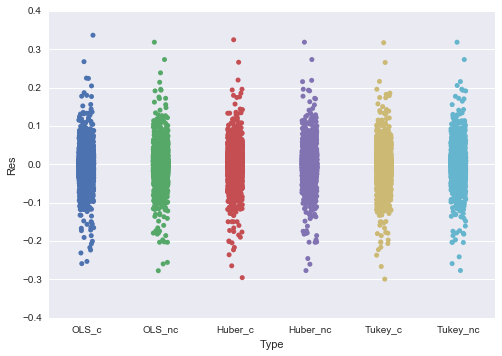

In [192]:
sns.stripplot(x="Type", y="Res", data=ResN, jitter=True)

For un-adjusted residuals, we could see that OLS with constant has the largest abosolute value of Residual at about 3.3. Huber with constant and Tukey with constant has some large residuals on negative sides.

Below is the distribution of all djusted residuals. 

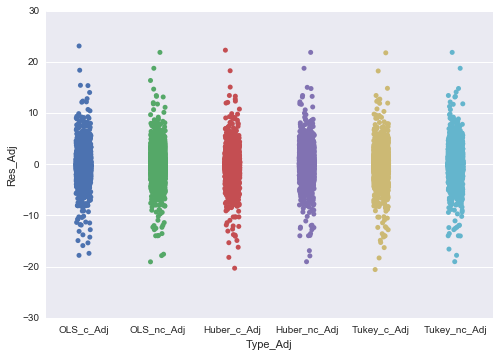

In [193]:
sns.stripplot(x="Type_Adj", y="Res_Adj", data=ResN, jitter=True)

For adjusted residuals, we could see they are all larger than the unadjusted ones, since the volatility are all smaller than 0. OLS with constant has the largest abosolute value of Residual at about 23. Huber with constant and Tukey with constant has some large residuals on negative sides.

## Deeper Analysis

In [200]:
#root of Mean squared error
def rmse(res):
    return np.sqrt((res**2).mean())
#mean absolute error
def mae(res):
    return res.abs().mean()

In [205]:
RiskM = pd.DataFrame()
for col in Res.columns[::2]:
    RiskM.ix['RMSE',col] = rmse(Res[col])
    RiskM.ix['MAE',col] = mae(Res[col])
RiskM

,Huber_c,Huber_nc,OLS_c,OLS_nc,Tukey_c,Tukey_nc
RMSE,0.037177,0.036825,0.037524,0.037126,0.037234,0.036788
MAE,0.022759,0.022523,0.023177,0.022729,0.022785,0.022510


Above the risk matrix for un-adjusted data. We could see that 
1. OLS with constant has highest RMSE. Tukey without constant has smallest RMSE.
2. OLS with constant has highest MAE. Tukey without constant has smallest RMSE.
3. OLS are worse than Huber and Tukey.
4. For both RMSE and MAE, no constant models are all better than constant models for all three model types.
5. Tukey without constant is the best model for prediction.

In [207]:
RiskM_Adj = pd.DataFrame()
for col in Res.columns[1::2]:
    RiskM_Adj.ix['RMSE',col] = rmse(Res[col])
    RiskM_Adj.ix['MAE',col] = mae(Res[col])
RiskM_Adj

,Huber_c_Adj,Huber_nc_Adj,OLS_c_Adj,OLS_nc_Adj,Tukey_c_Adj,Tukey_nc_Adj
RMSE,2.555744,2.531569,2.579609,2.552213,2.559624,2.529020
MAE,1.564552,1.548329,1.593288,1.562500,1.566332,1.547431


Above the risk matrix for un-adjusted data. We could see that 
1. OLS with constant has highest RMSE. Tukey without constant has smallest RMSE.
2. OLS with constant has highest MAE. Tukey without constant has smallest RMSE.
3. OLS are worse than Huber and Tukey.
4. For both RMSE and MAE, no constant models are all better than constant models for all three model types.
5. Tukey without constant is the best model for prediction.

## Conclusion

1. OLS works worse than Huber and Tukey.
2. OLS with constant is the worst model for prediction. 
3. Tukey without constant is the best model for prediction.